In [1]:
#//////////////////////////////////////////////////////

# p5607 -- RUN5

#//////////////////////////////////////////////////////

In [2]:
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
from sideblock_distances import DistanceSensorsVessel
from ac_res_anlys_funcs import loadResFullrun, loadAcSettings, interpDat, TSplot, pickTOF
import h5py as h5

import matplotlib.pyplot as plt
import matplotlib as mpl

from bokeh.plotting import figure, show, save
from bokeh.io import output_notebook, output_file, reset_output
from bokeh.layouts import gridplot, row, column
output_notebook()

Loading BokehJS ...

Loading BokehJS ...

In [3]:
def read_hdf(fileName, opts=[]):
    # print(len(opts))
    data = pd.DataFrame()
    if len(opts) == 0:
        for chanName in h5.File(fileName, "r").keys():
            data[chanName] = h5.File(fileName, "r")[chanName]
    else:
        for chanName in opts:
            data[chanName] = h5.File(fileName, "r")[chanName]
    return data

In [4]:
SAVE = 1
runname = 'p5607'
run = 'run5'

mechDat = read_hdf('../'+runname+'_r.hdf5', ['effNS', 'time', 'Sync'])
thDat = read_hdf('../'+runname+'_Thickness.hdf5')

[Amp, AmpRef, Filter, FreqQ, LocalAcTime, MaxInter, 
NZPad, NtoStack, RmsAmp, RmsAmpRef, TimeRange, TimeShift, 
freqQAmp, fullWFref, idx2analyze, maxAmp, maxFreq, ref, threshold] = loadResFullrun('../Results/Results_'+runname+'_'+run+'_fullrun_Stack3WFs_absref_wAmp.mat')

acSettings, numCHR, numCHT, Nsamples, fs = loadAcSettings('matfiles/'+runname+'_'+run+'.mat')

idxAc, MaxInterI, TimeShiftI, RmsAmpI, freqQAmpI, maxAmpI, maxFreqI = interpDat(mechDat['time'], LocalAcTime, numCHR, numCHT, MaxInter, TimeShift, RmsAmp, freqQAmp, maxAmp, maxFreq)

del LocalAcTime, MaxInter, TimeShift, RmsAmp, freqQAmp, maxAmp, maxFreq

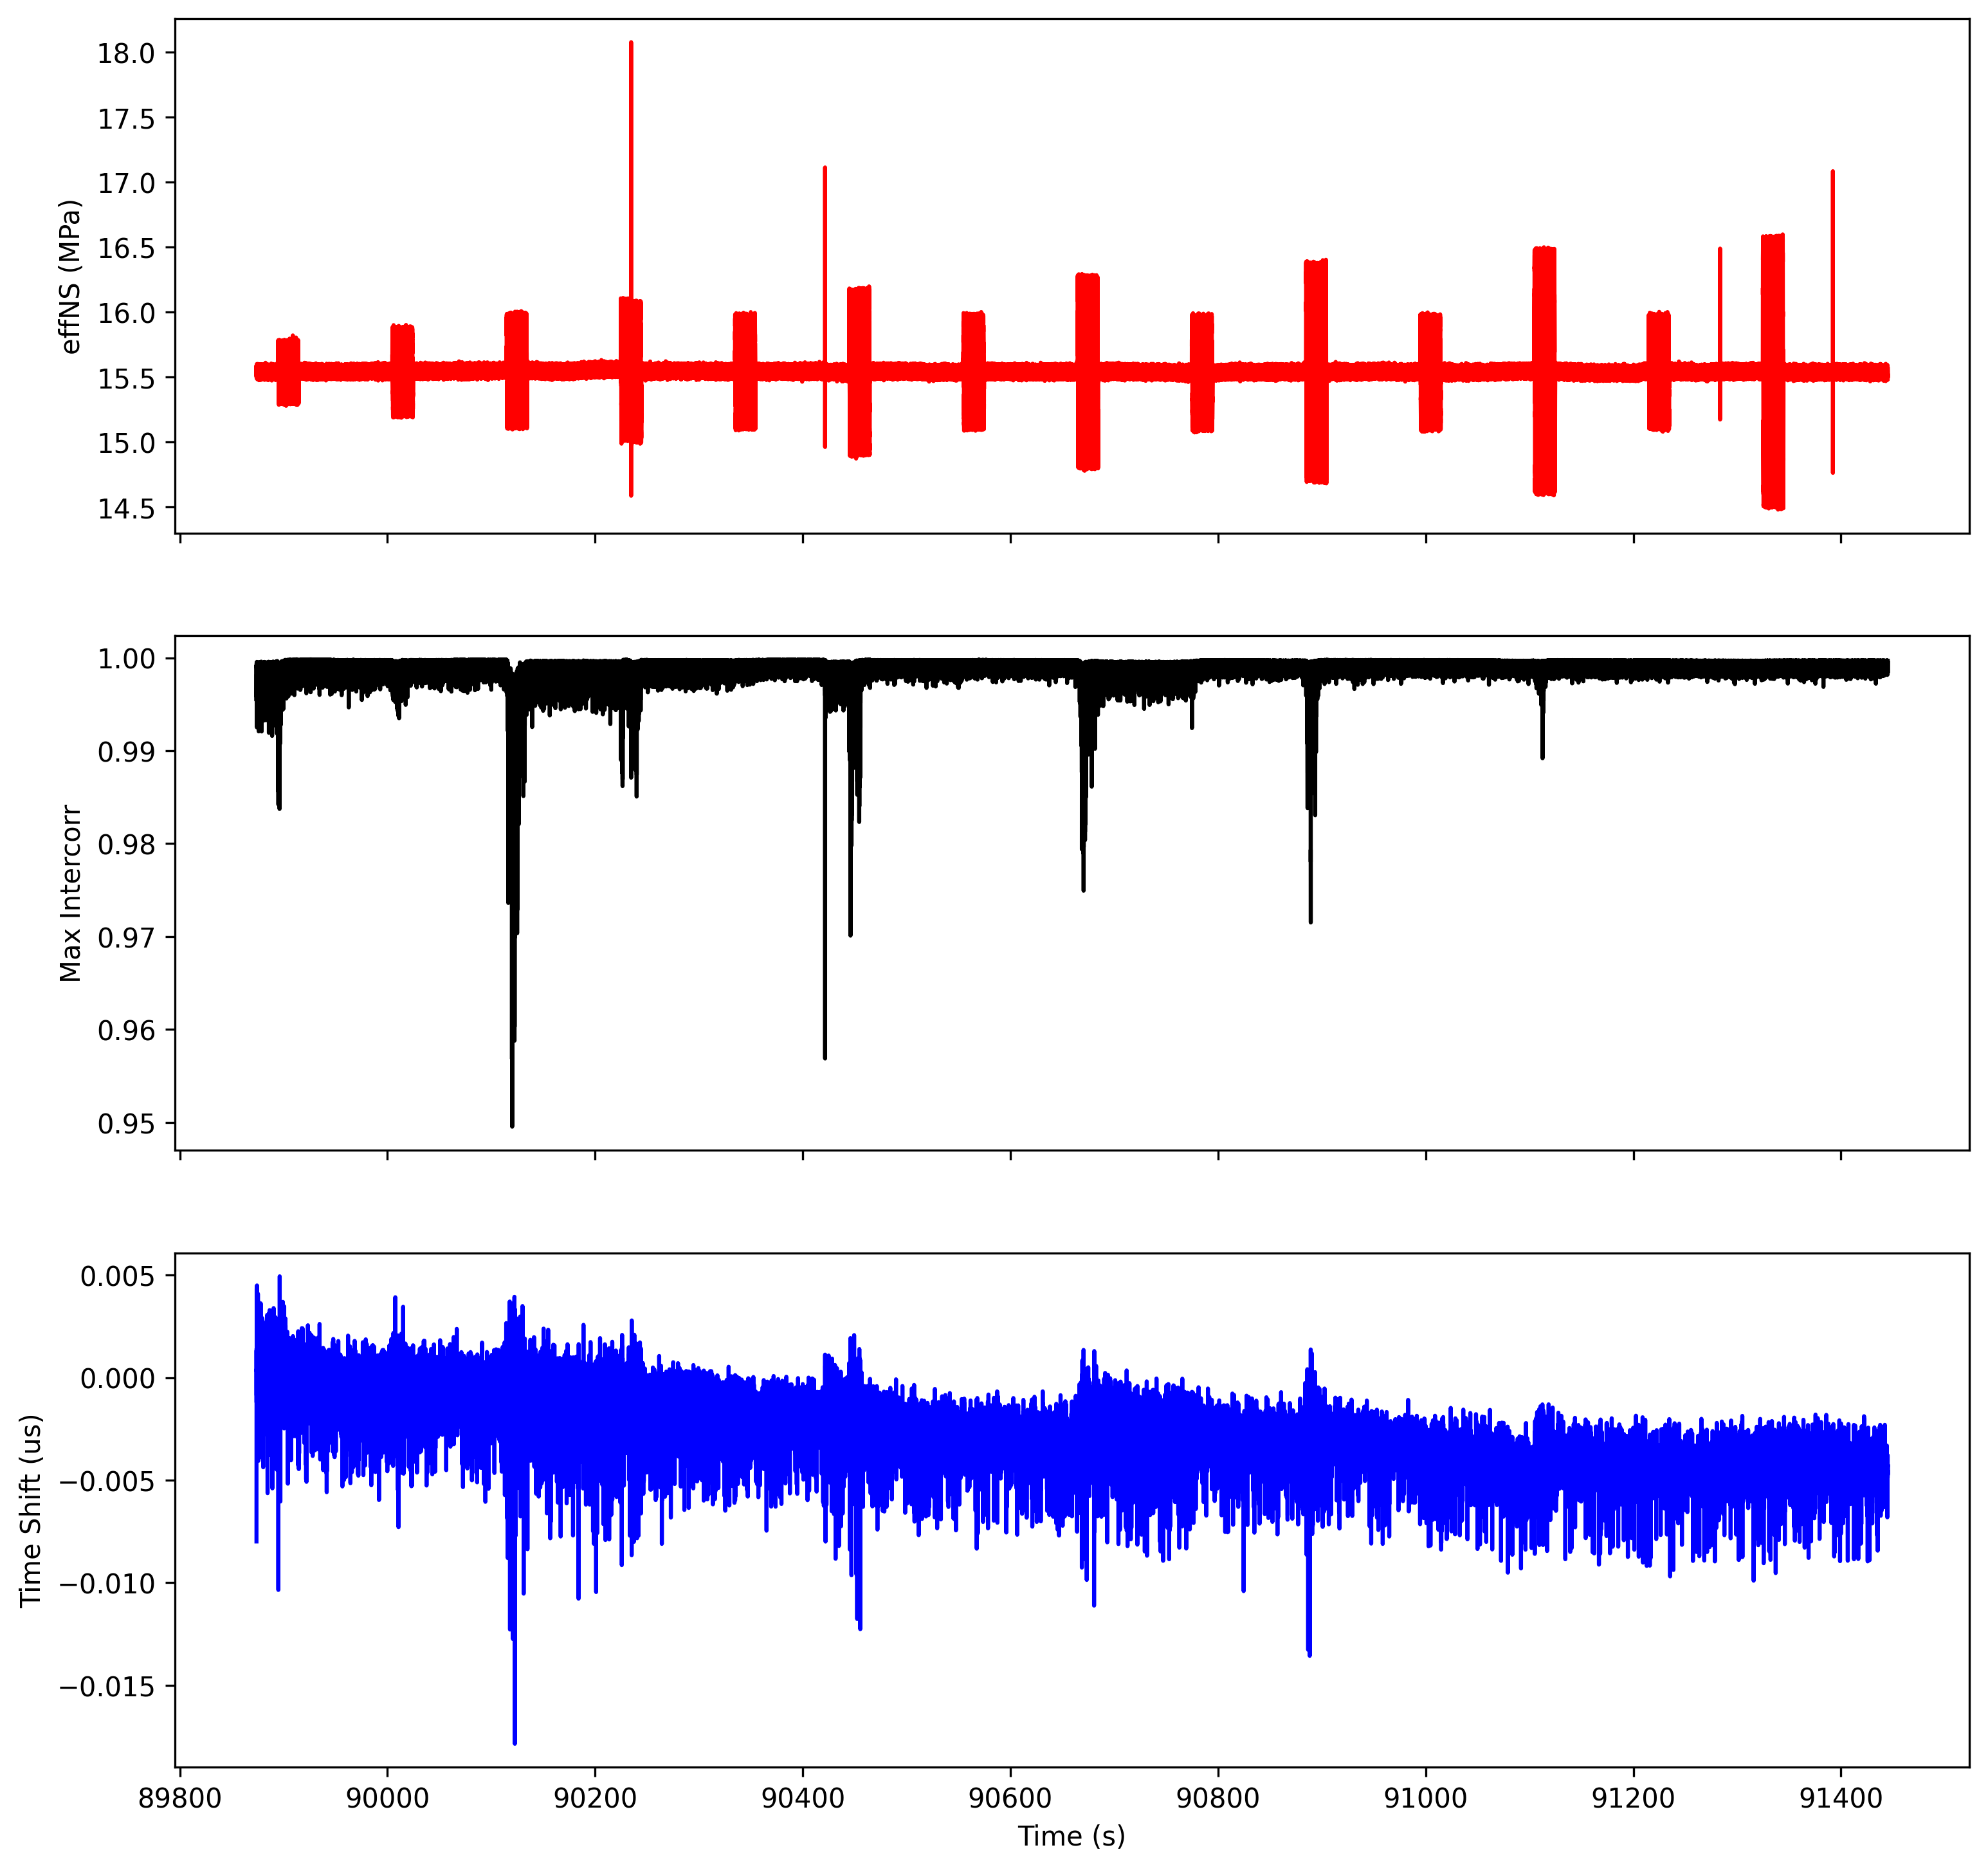

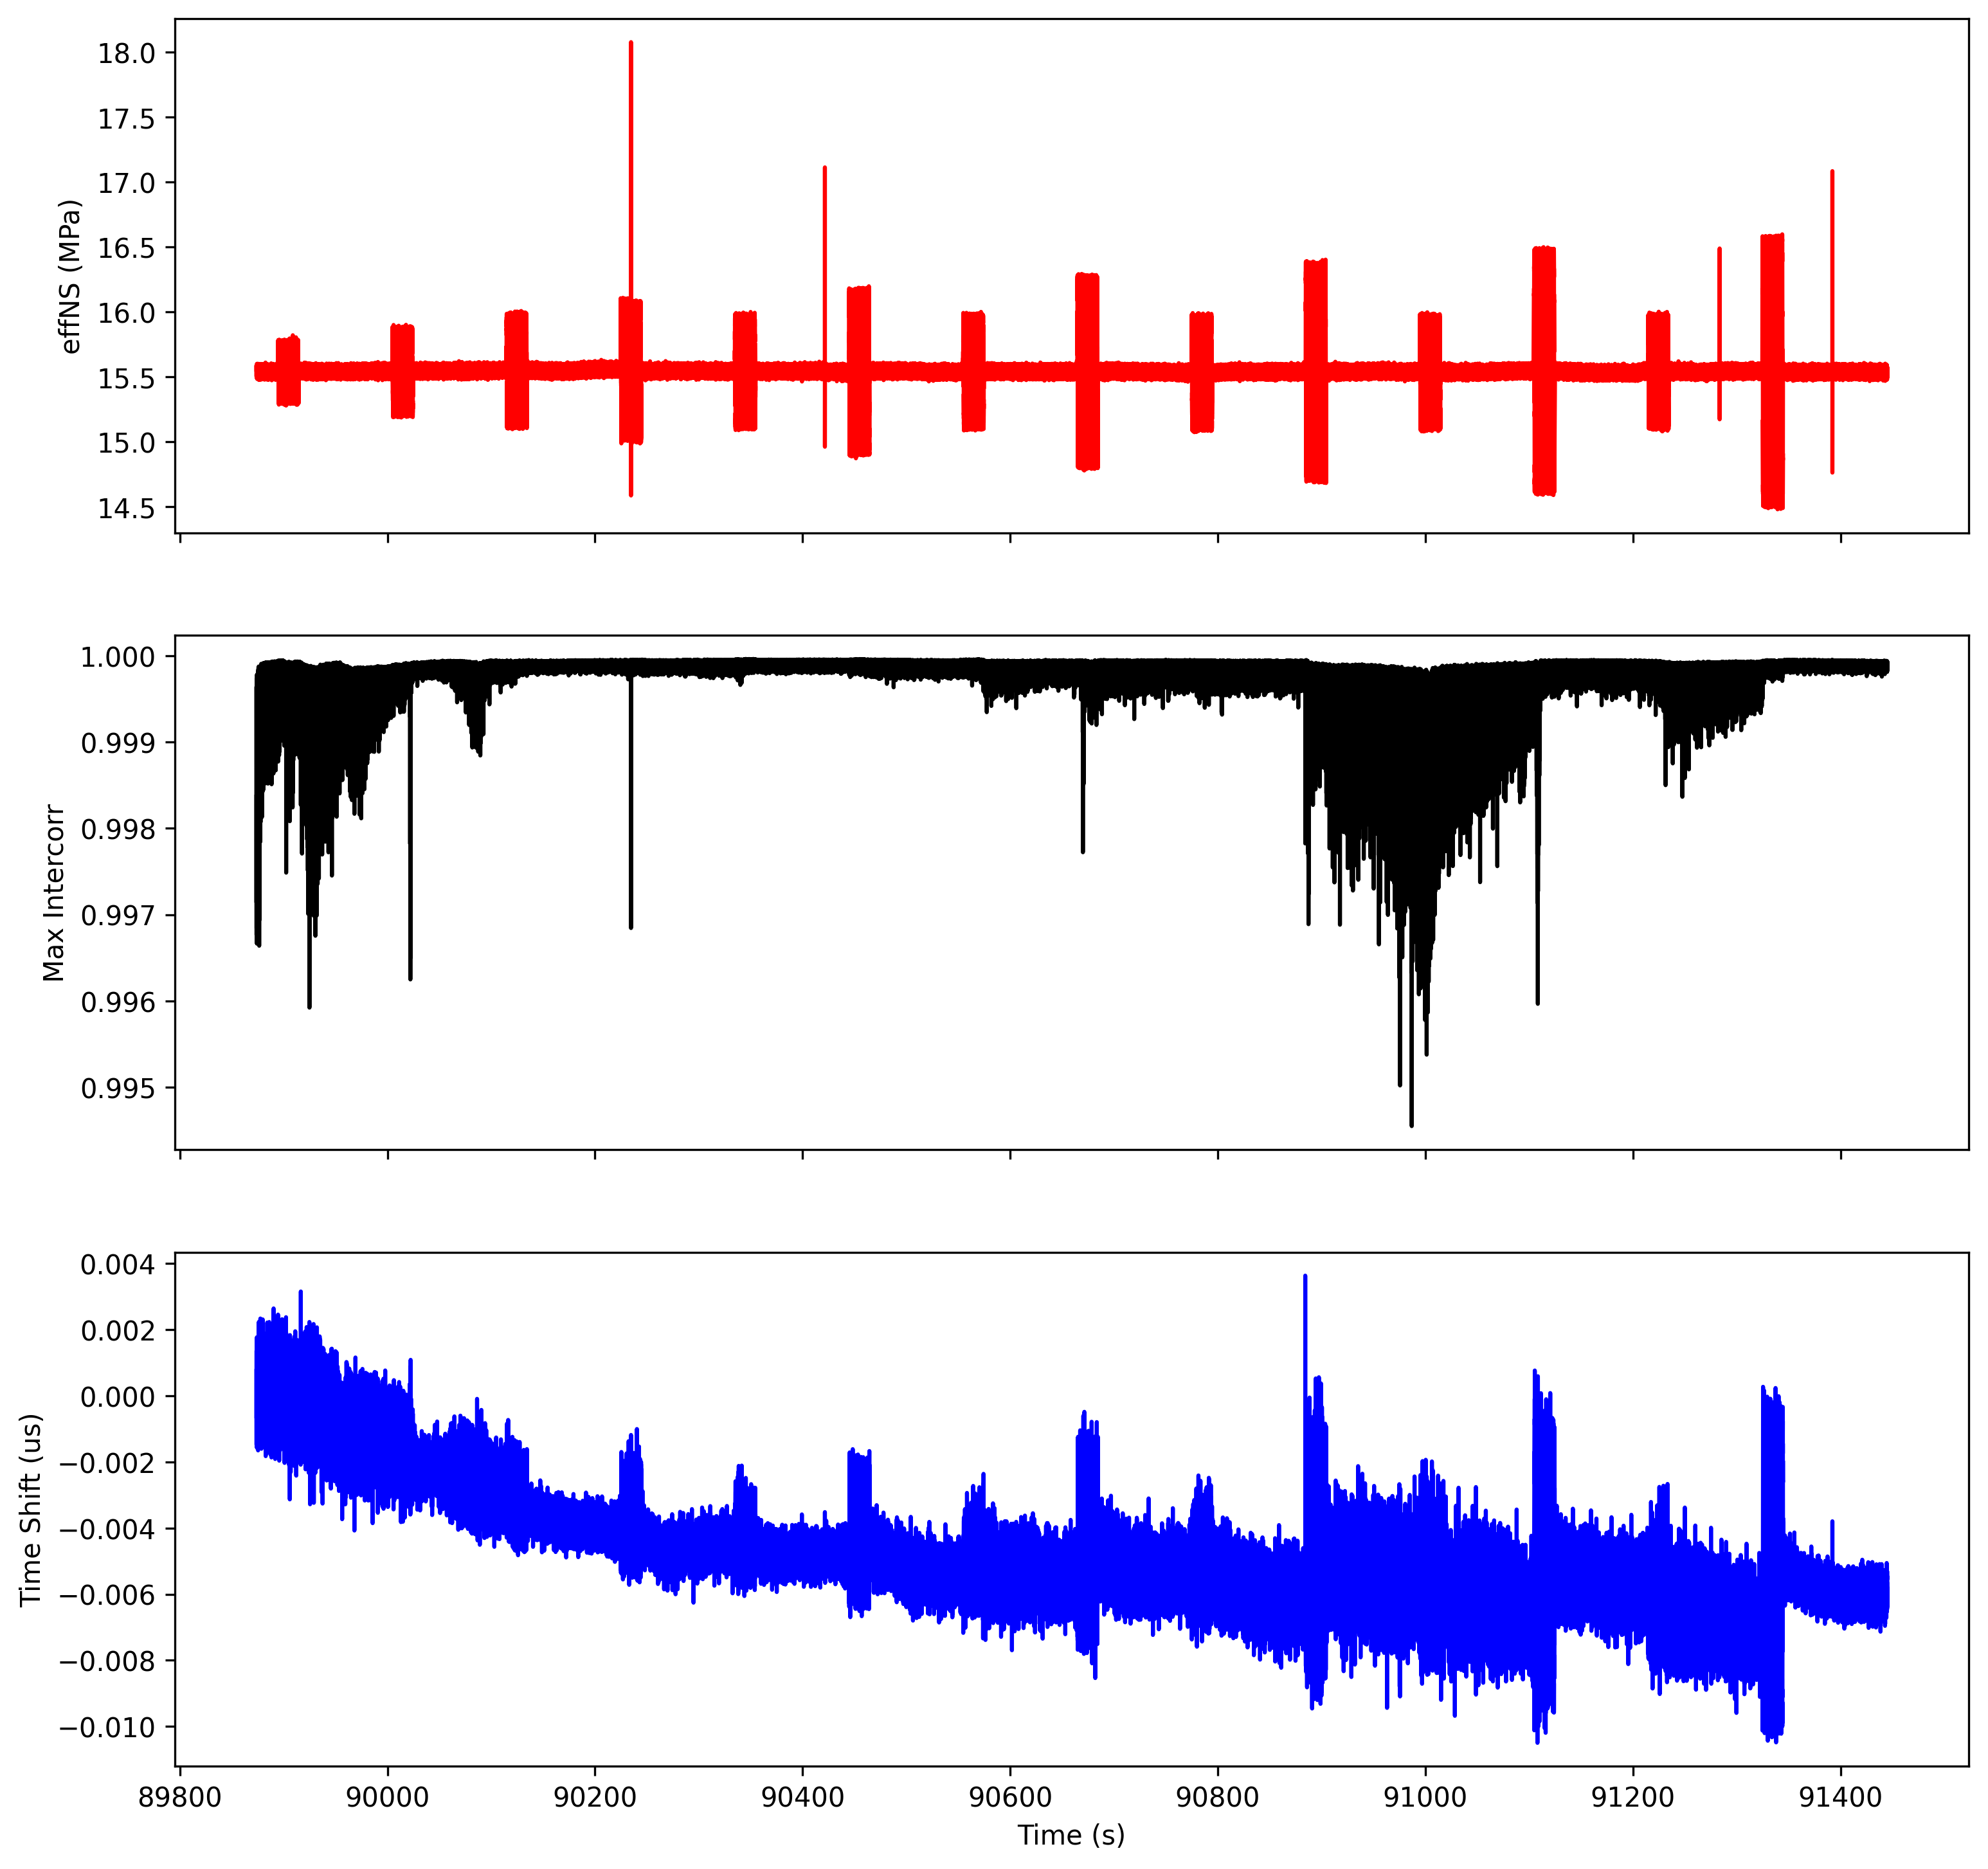

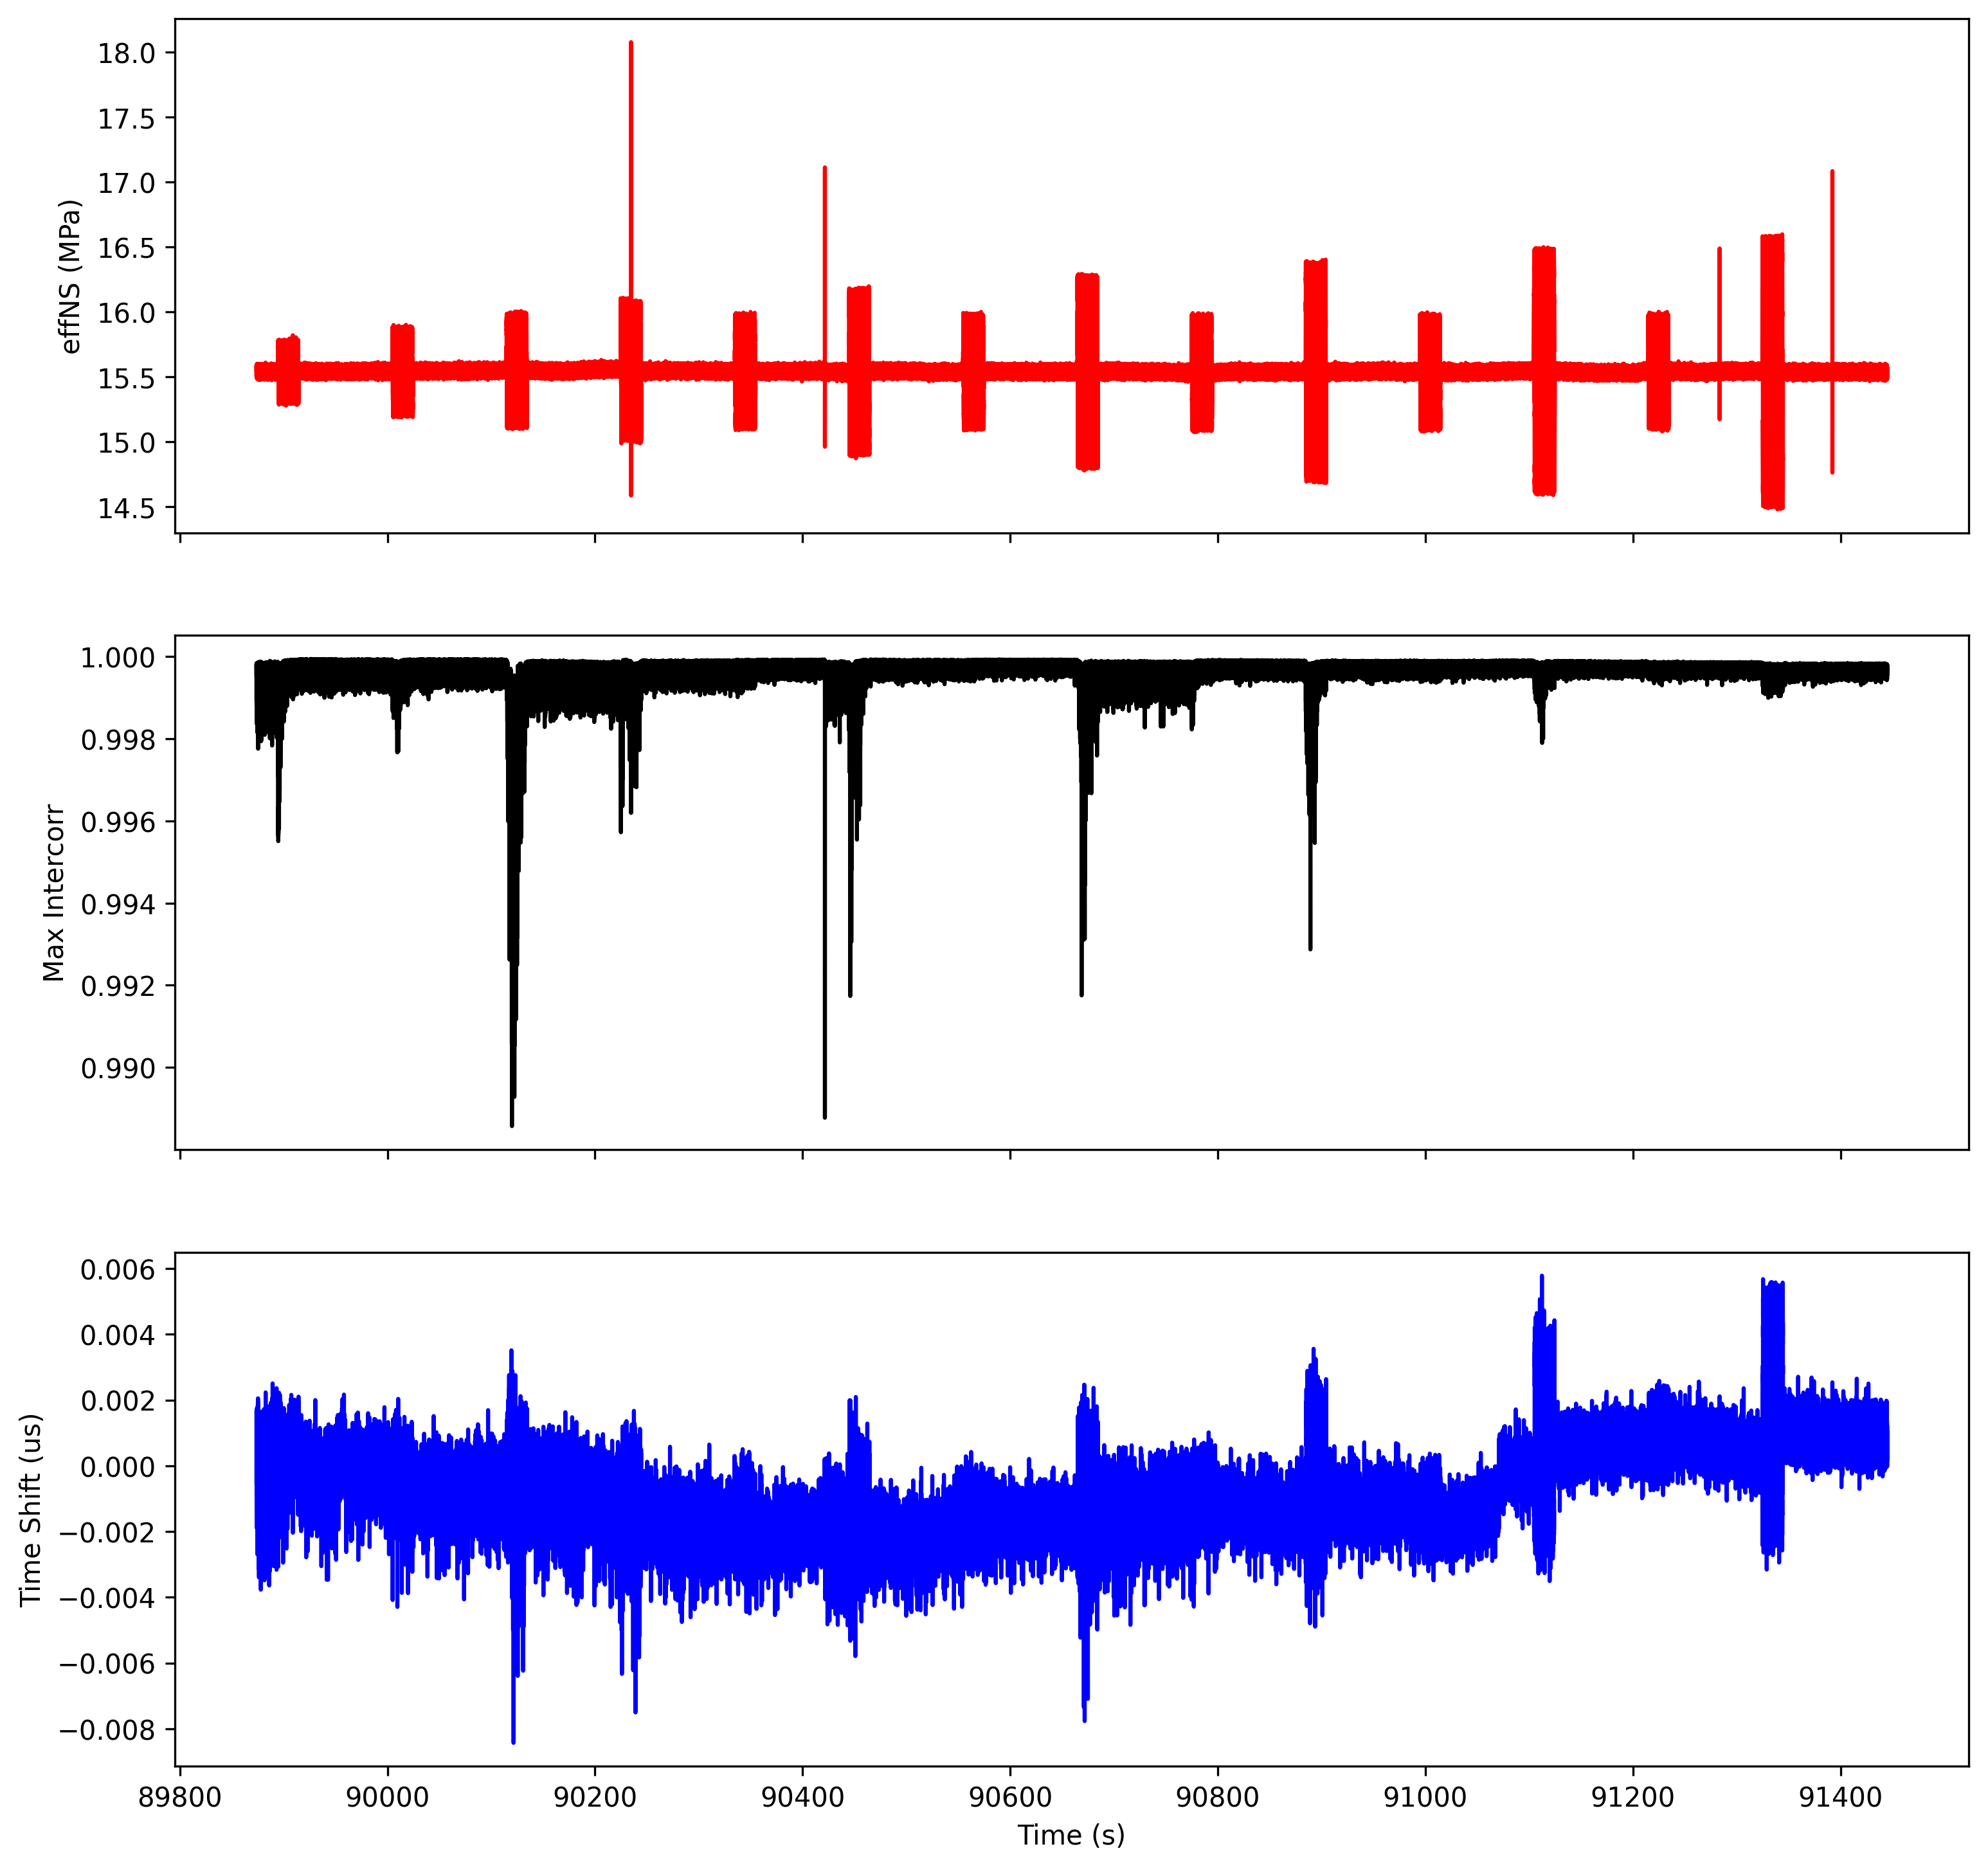

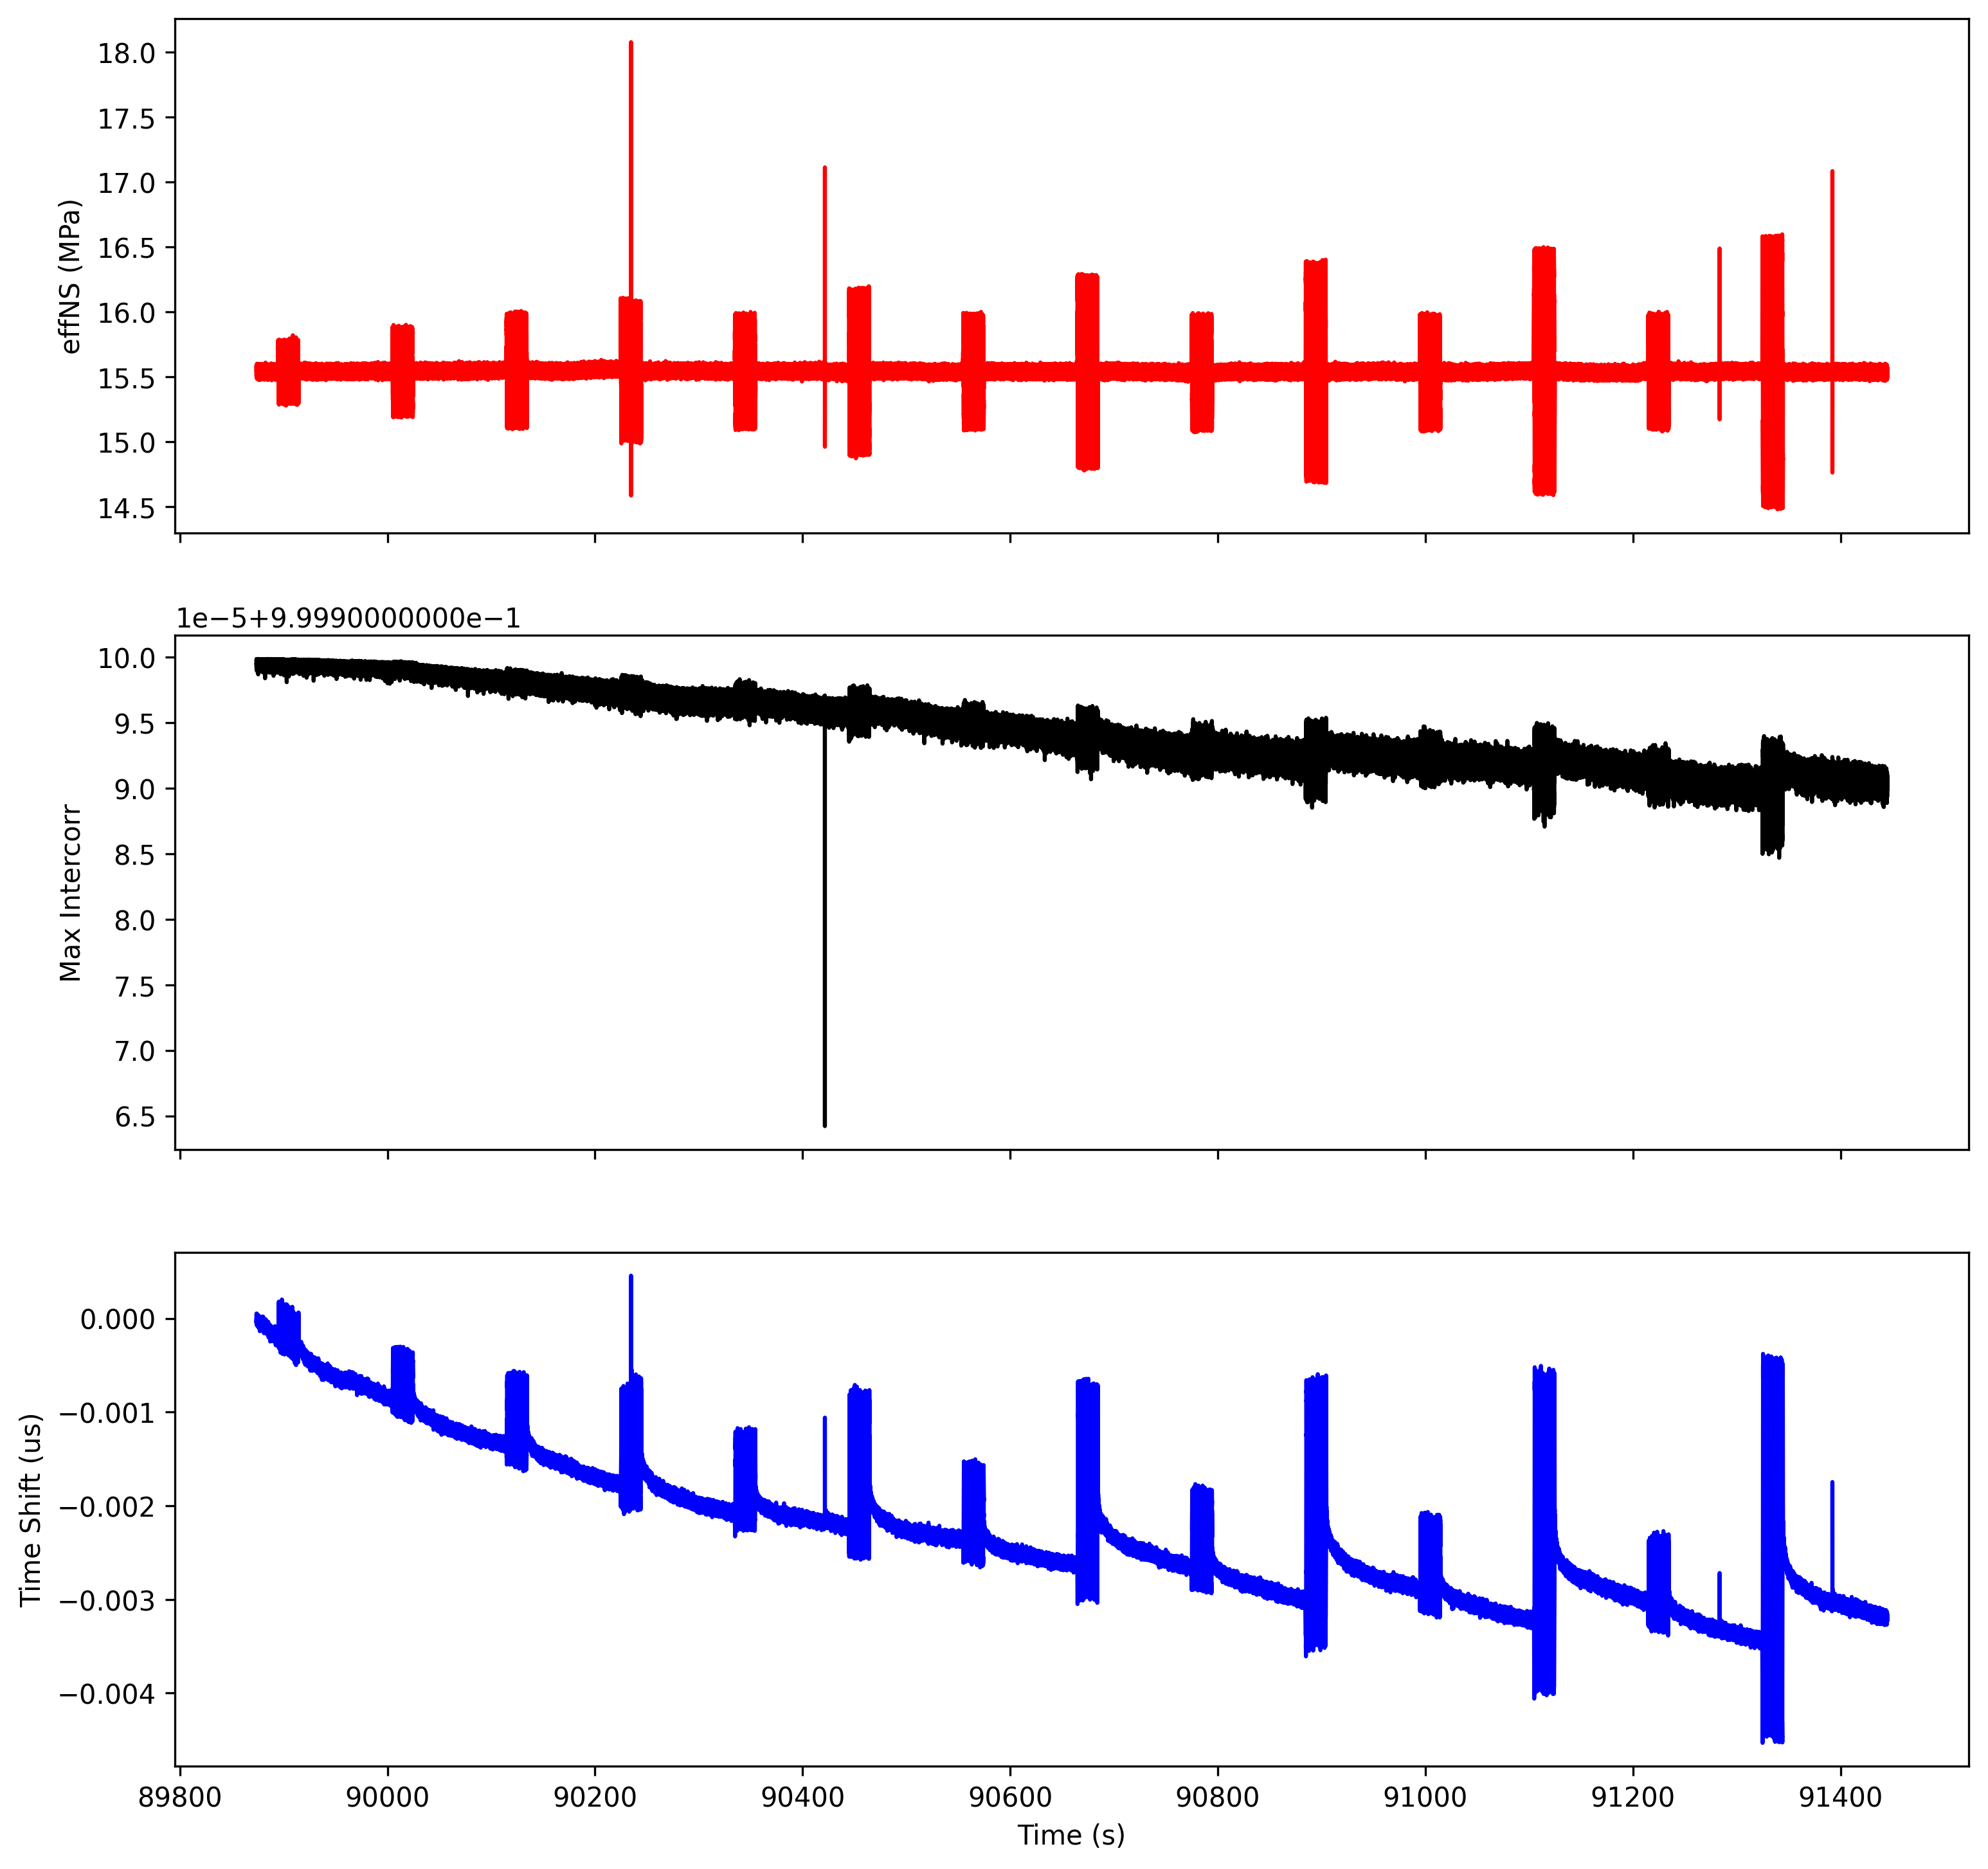

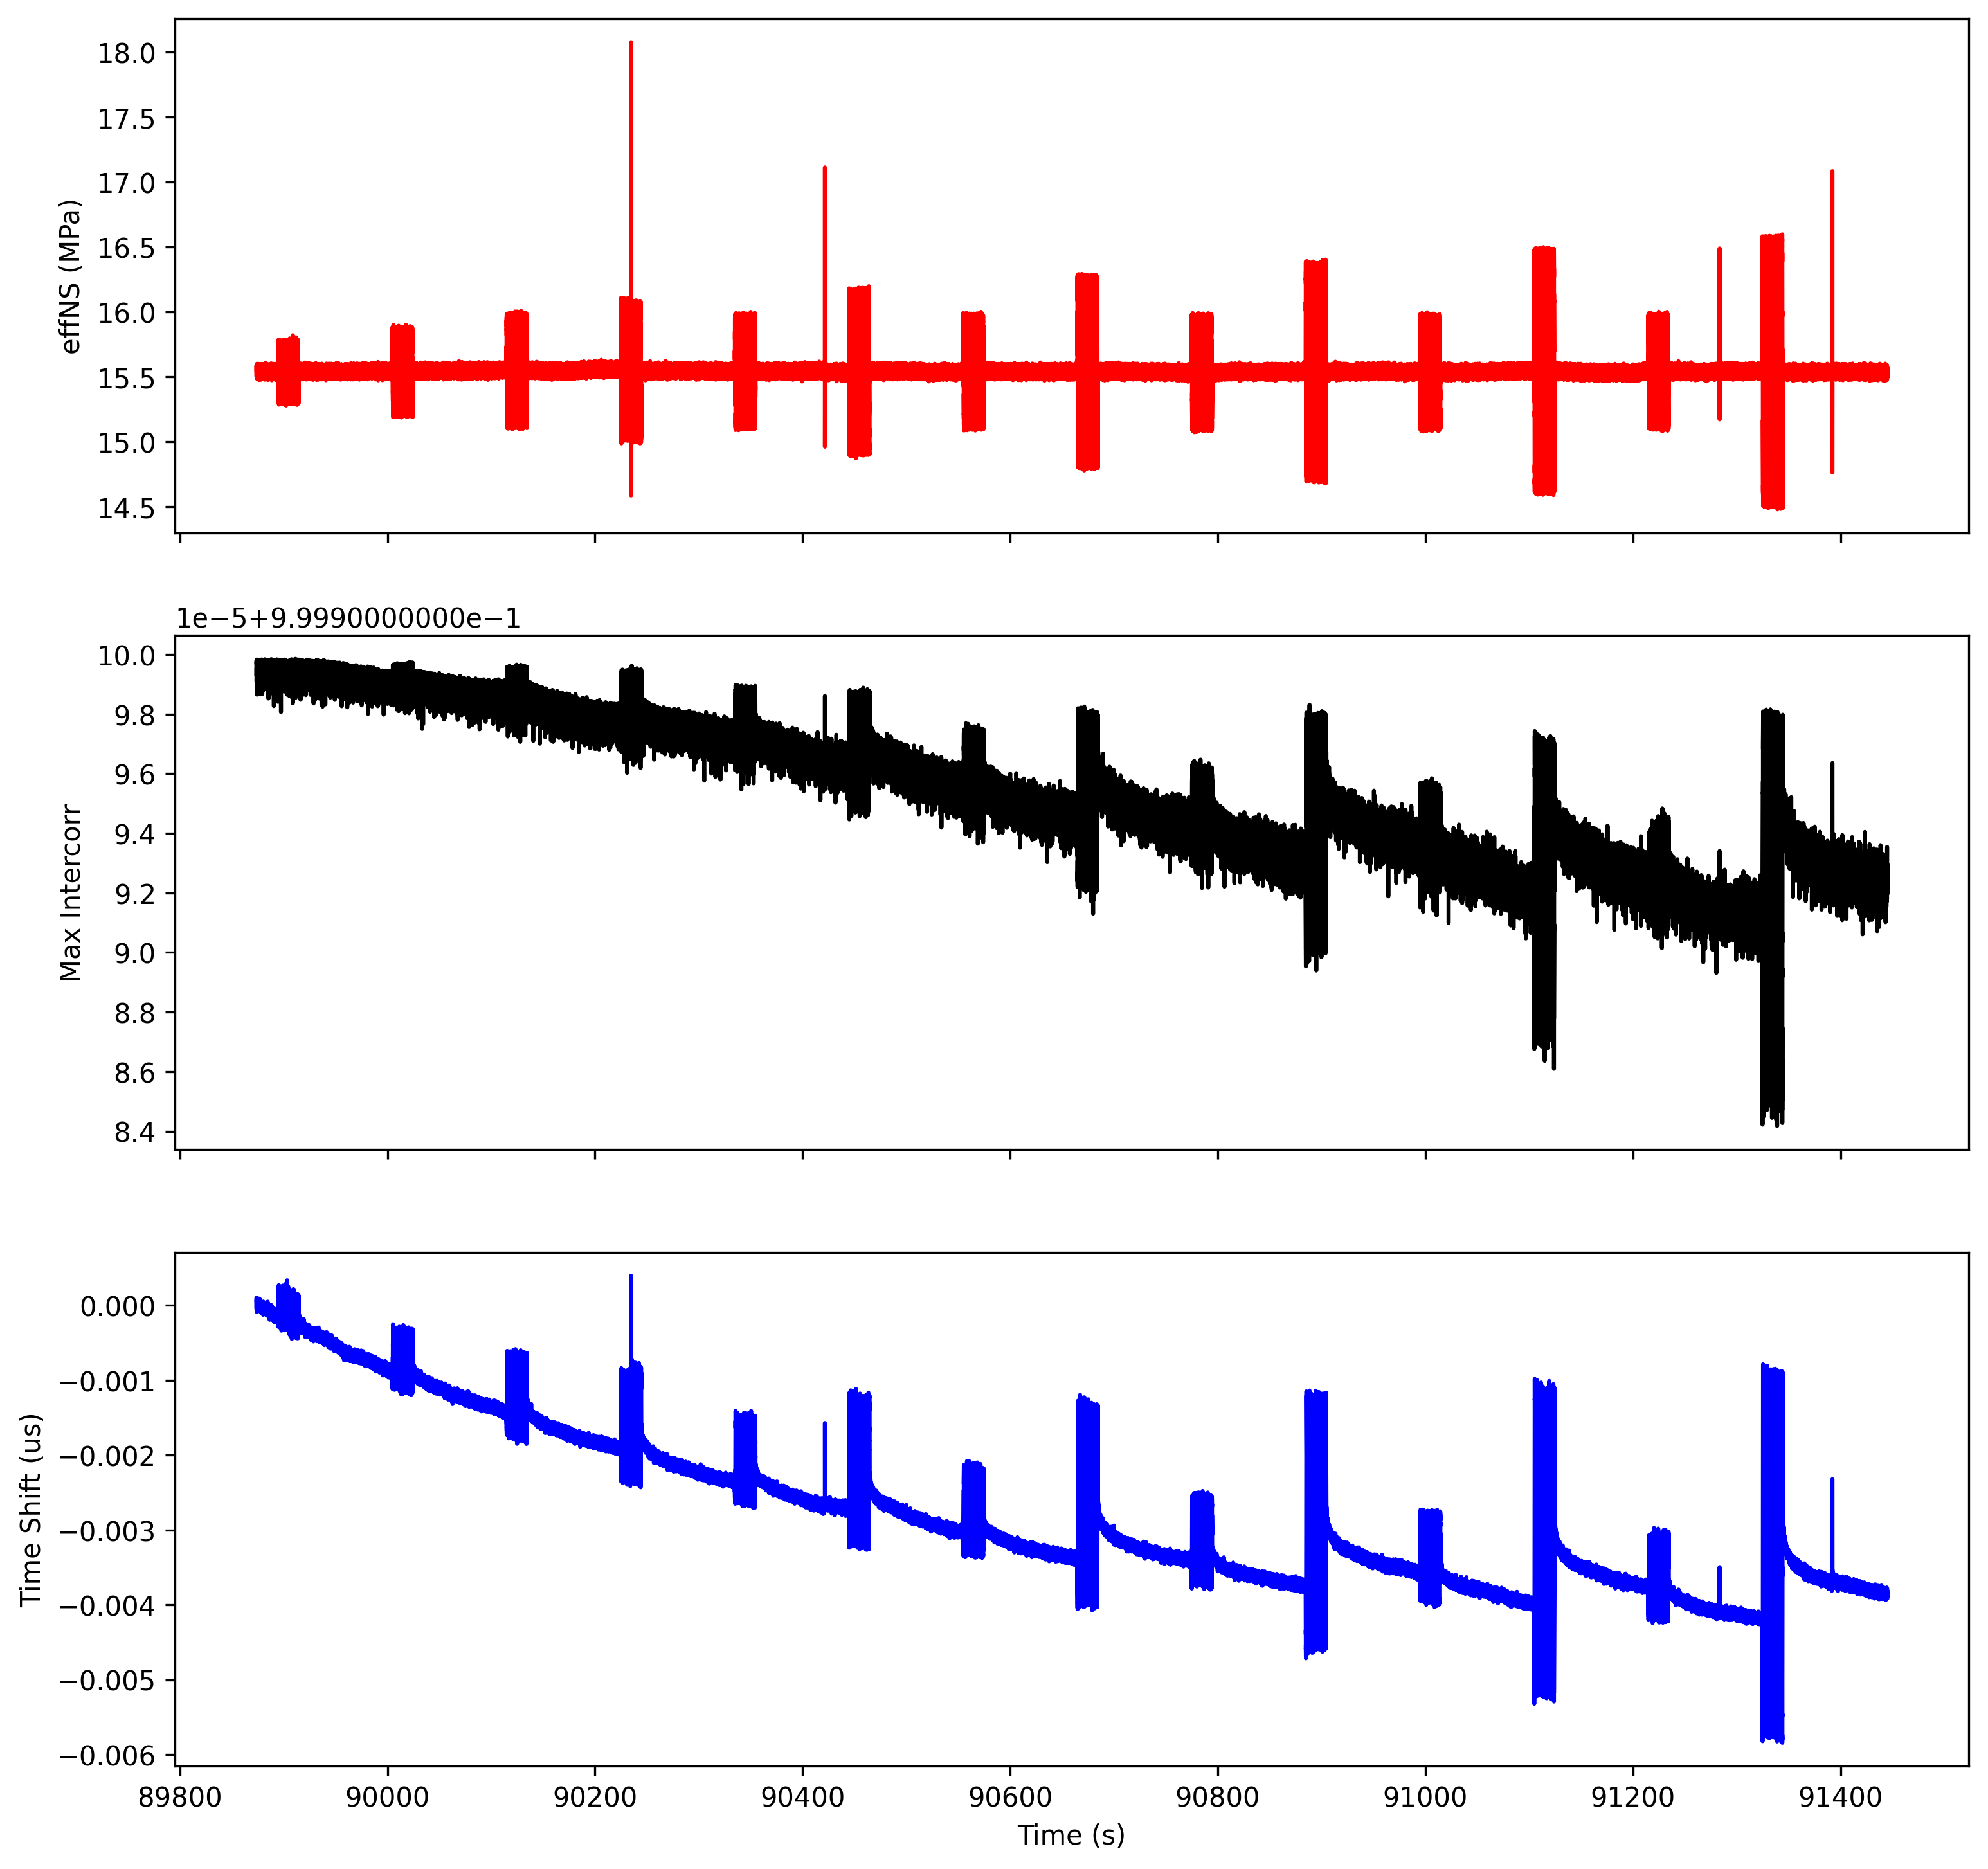

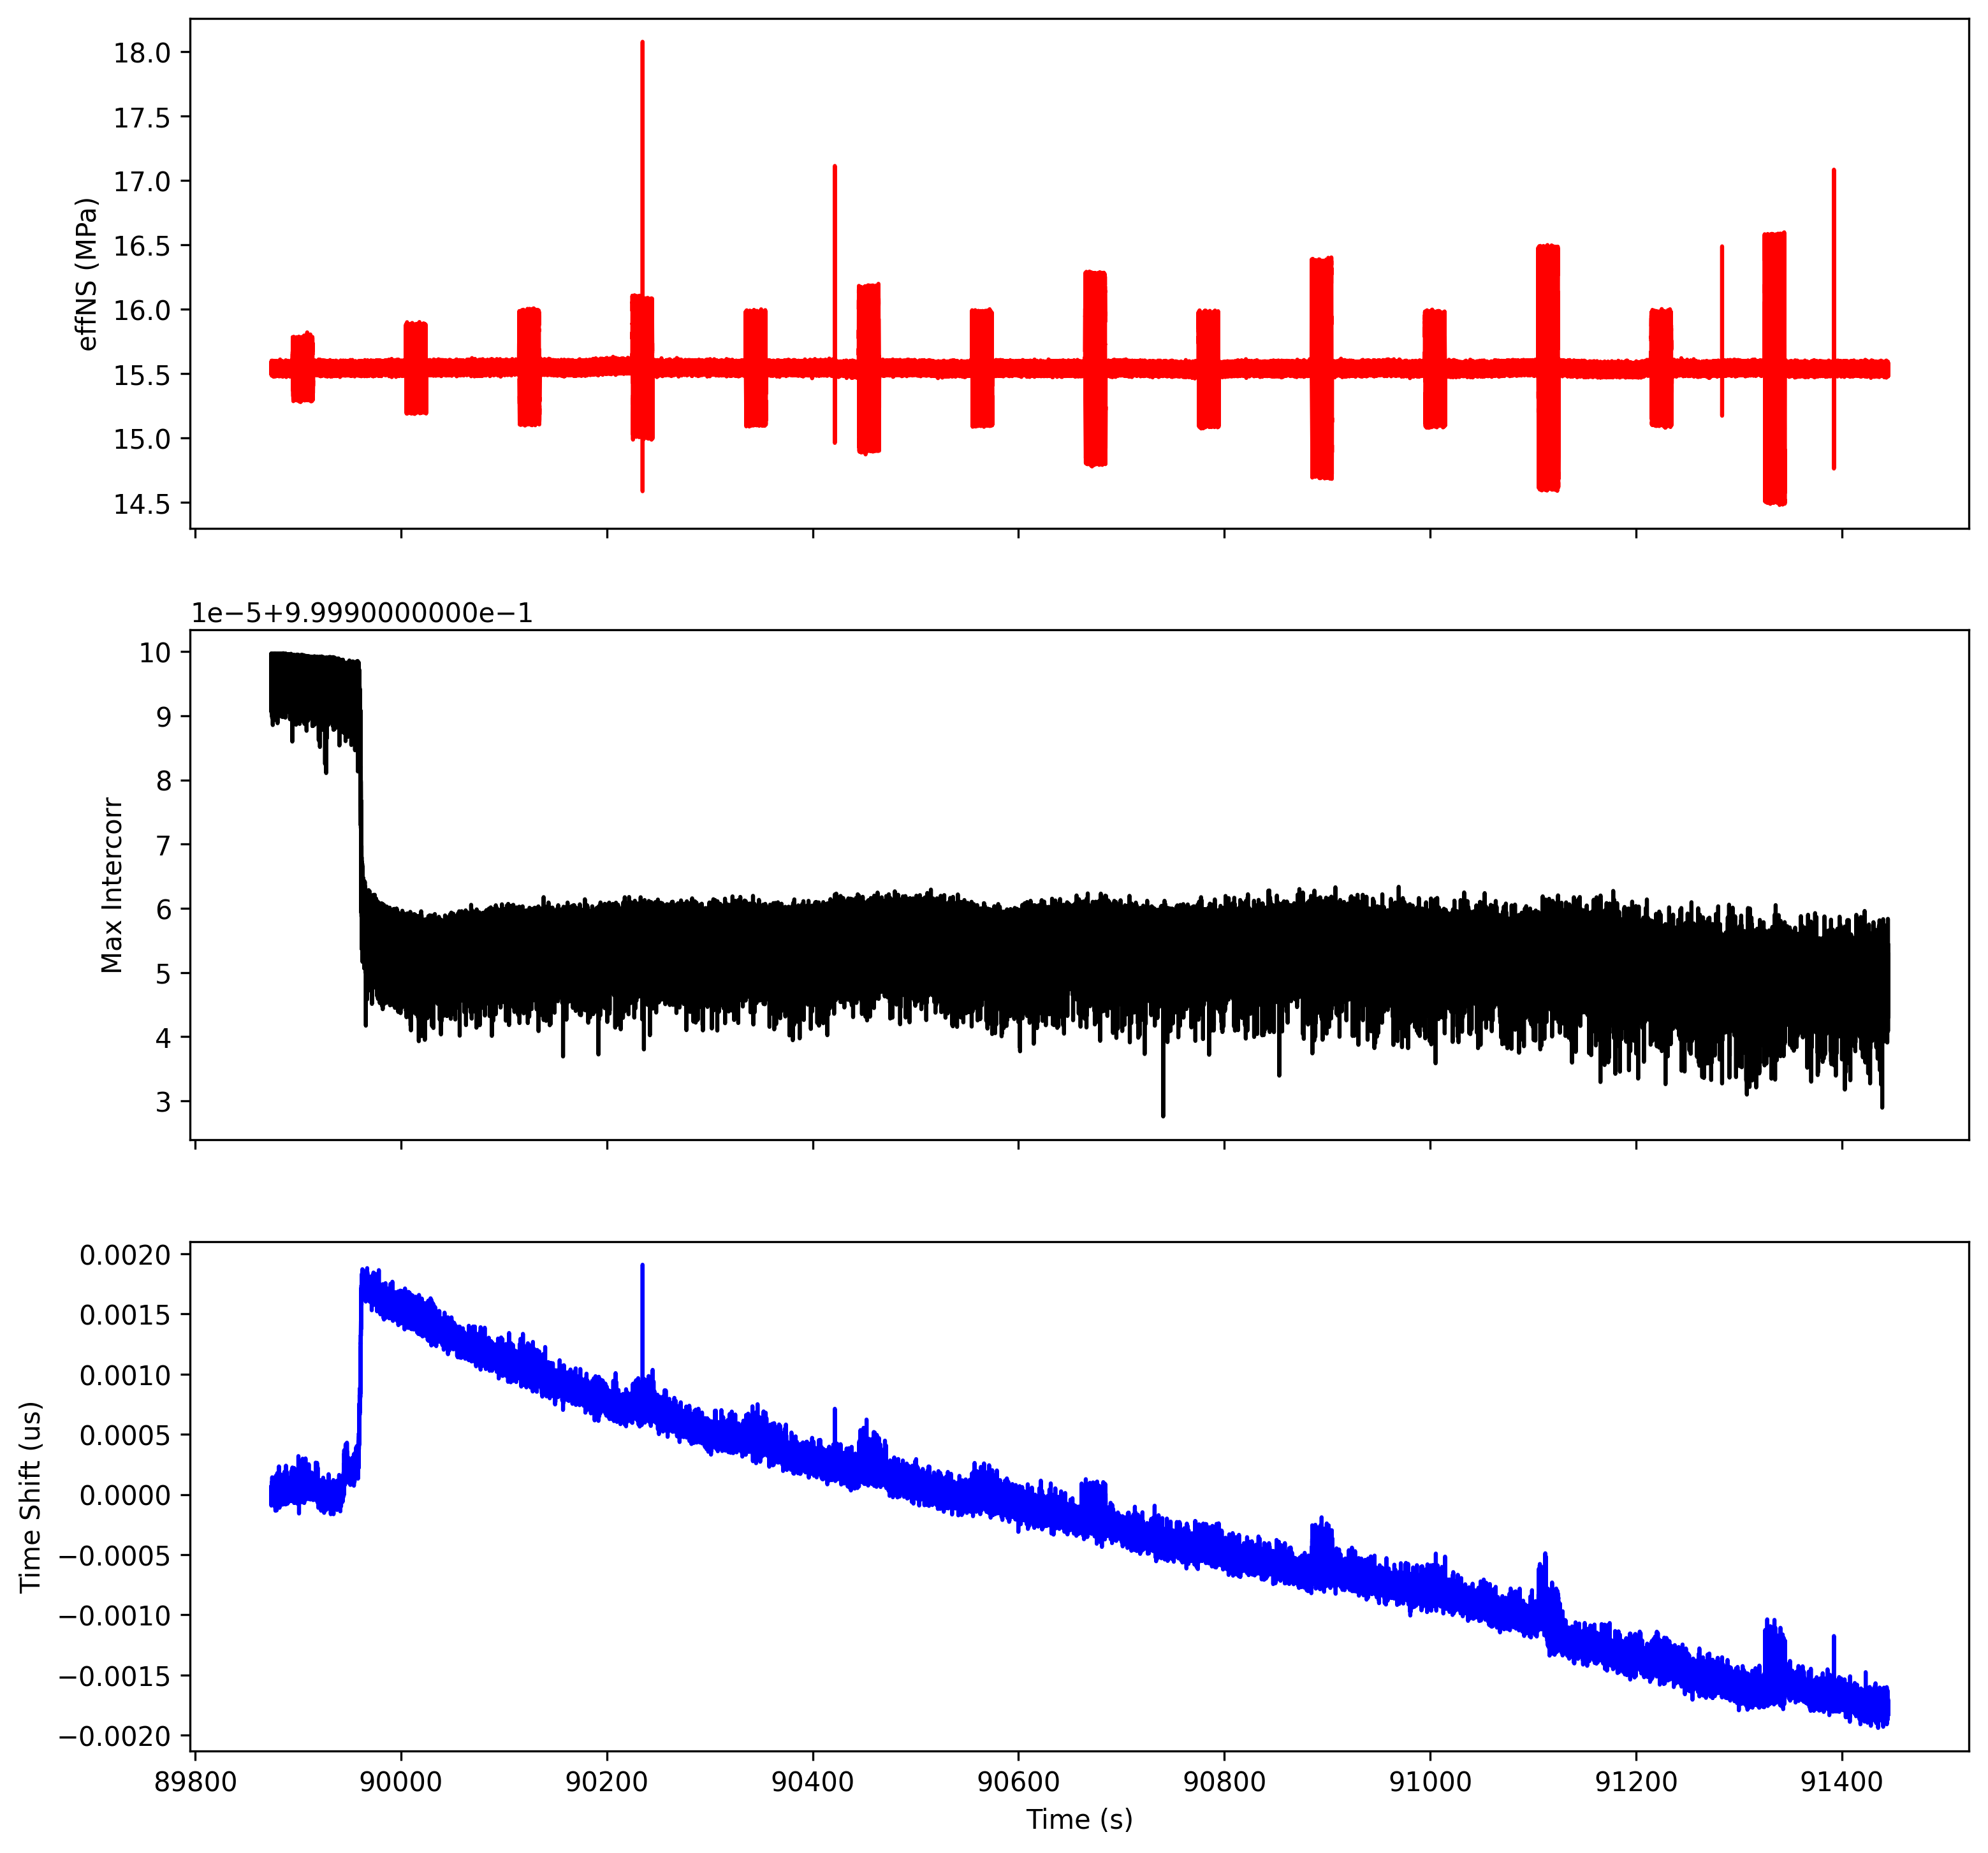

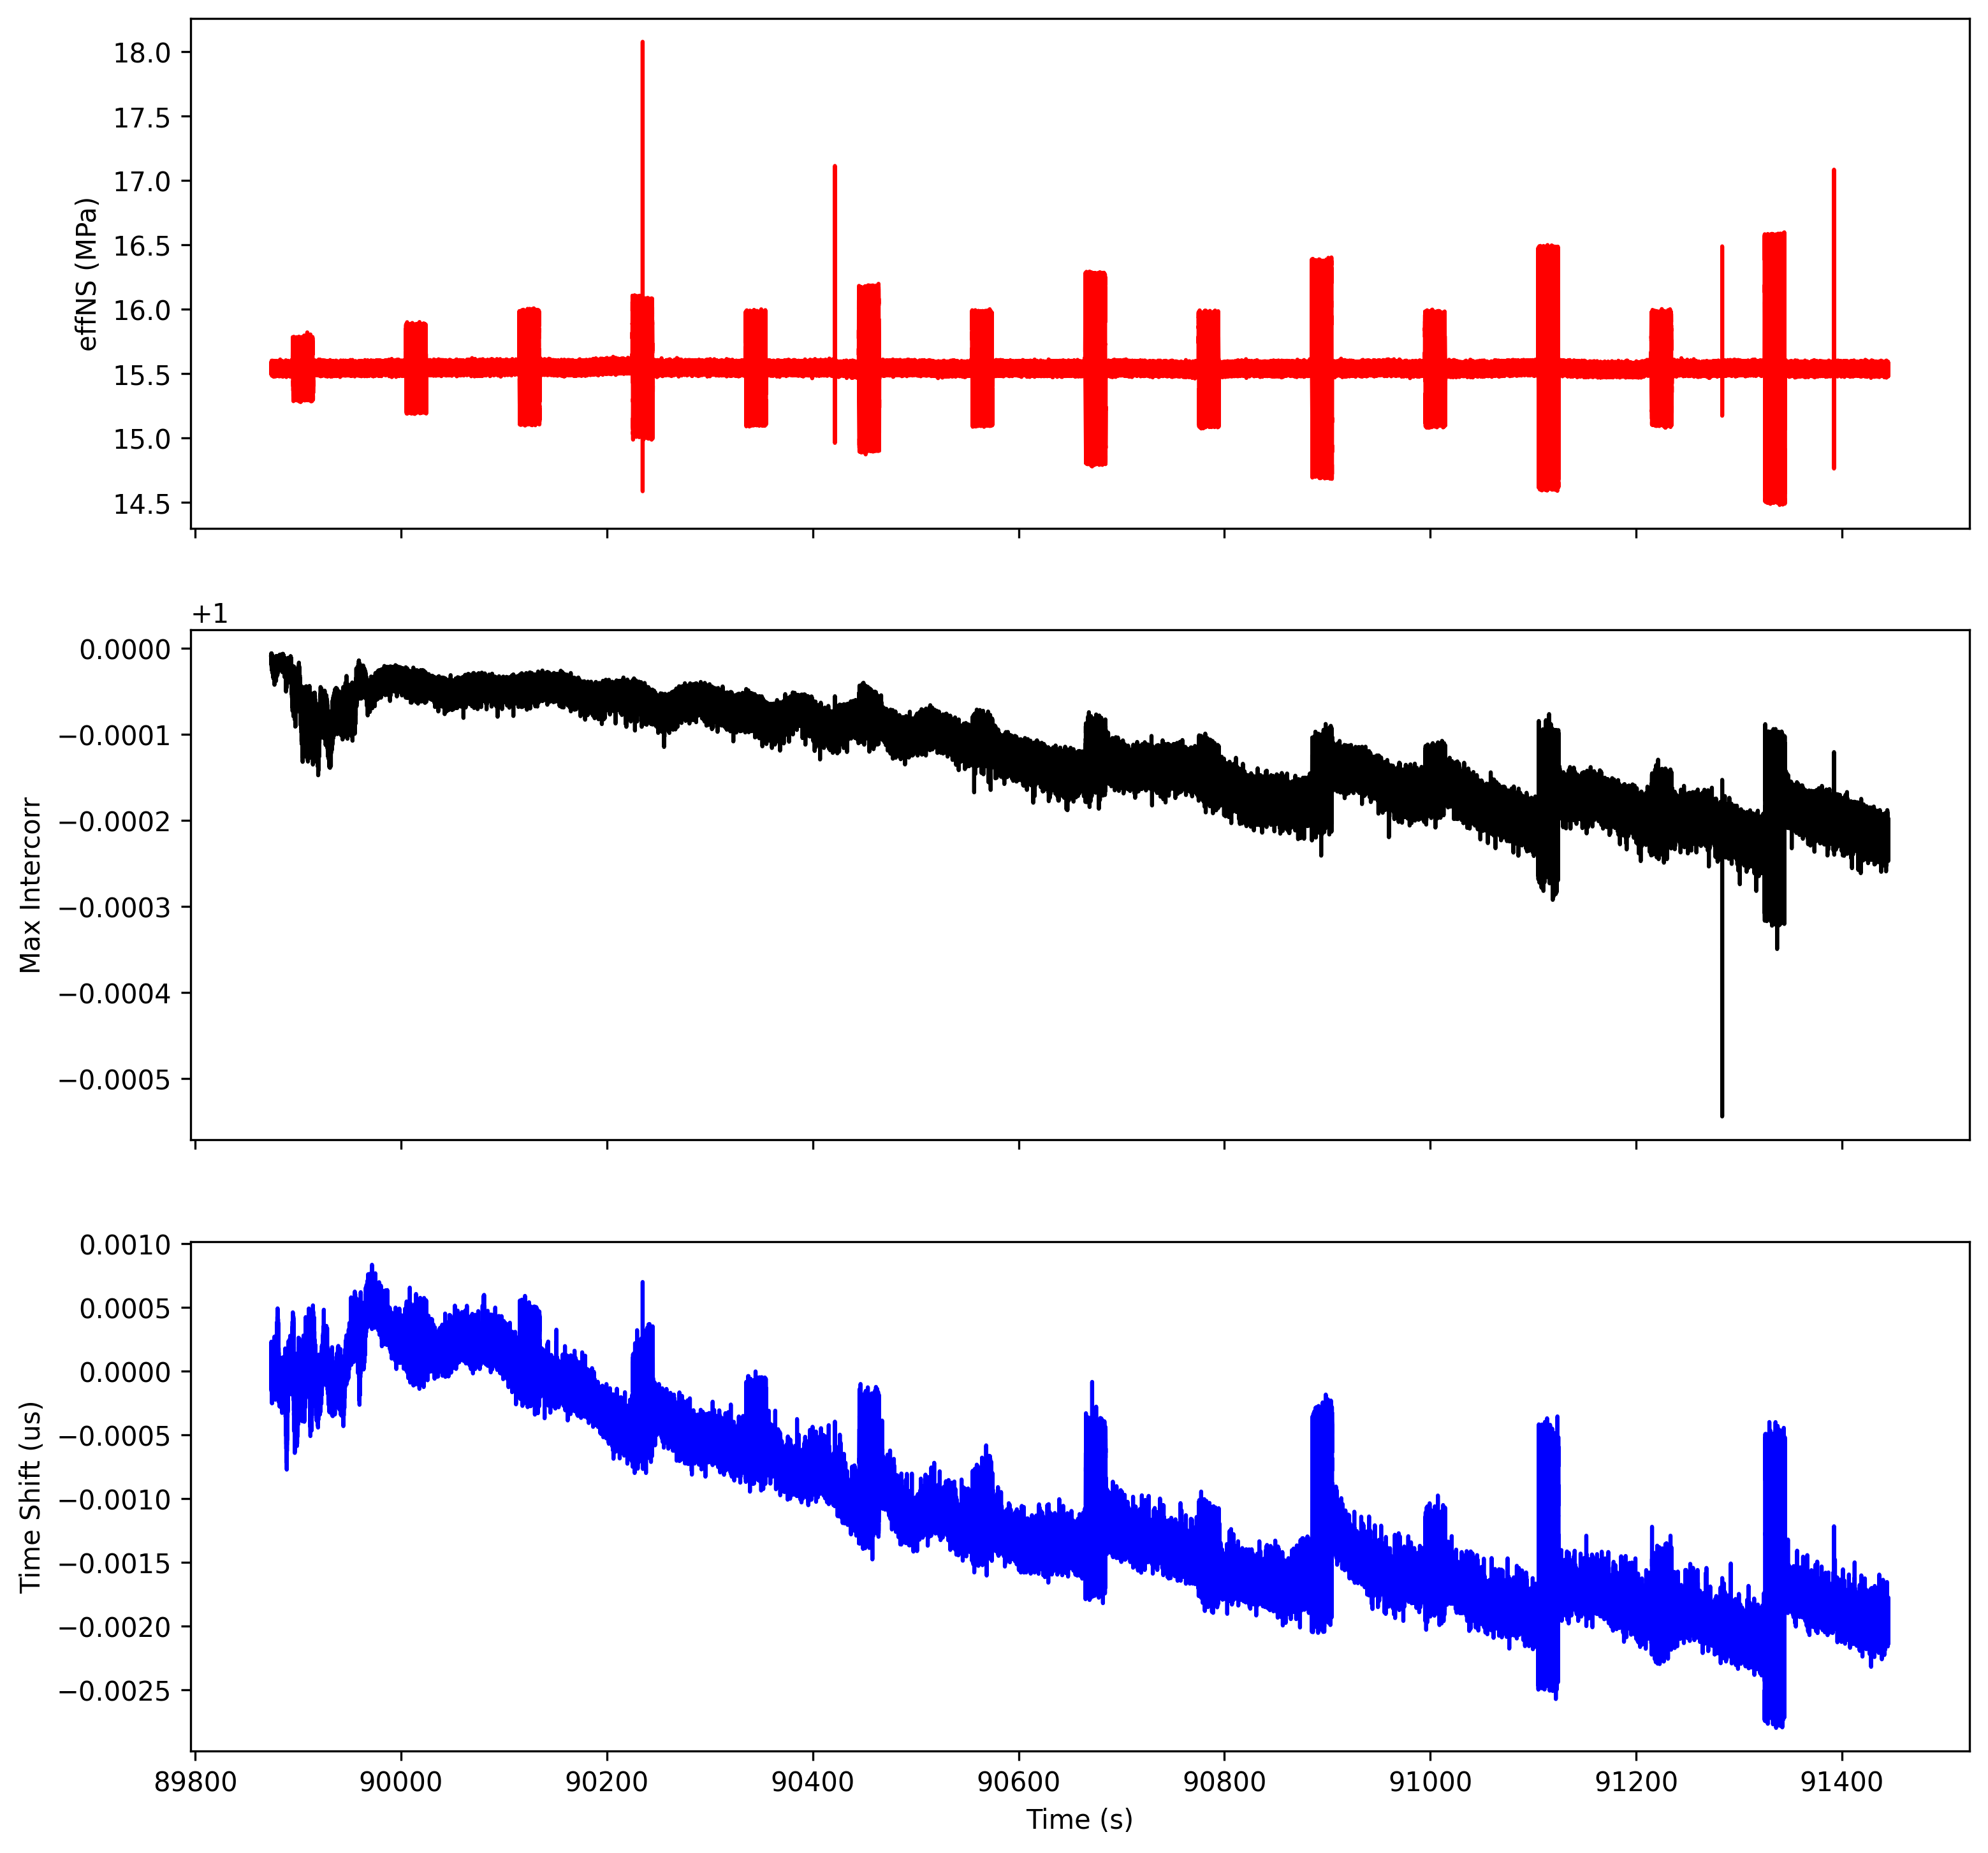

In [5]:
T = 0
R = 0

# from ac_res_anlys_funcs import *
for aa in range(7):
    # TSplot(idxAc, mechDat['time'], mechDat['effNS'], MaxInterI, TimeShiftI, aa, aa, runname, run, SAVE)
    %matplotlib inline
    fig, axs = plt.subplots(3, 1, figsize=(12, 12), dpi=300, sharex=True)
    axs[0].plot(mechDat['time'][idxAc], mechDat['effNS'][idxAc], color='red')
    axs[0].set_ylabel('effNS (MPa)')
    axs[1].plot(mechDat['time'][idxAc], MaxInterI[:,aa,aa], color='black')
    axs[1].set_ylabel('Max Intercorr')
    axs[2].plot(mechDat['time'][idxAc], TimeShiftI[:,aa,aa], color='blue')
    axs[2].set_ylabel('Time Shift (us)')
    axs[2].set_xlabel('Time (s)')
    plt.show()
    fig.savefig('../Results_wAmp/'+runname+'_'+run+'_timeshift_unFilt_T'+str(aa+1)+'R'+str(aa+1)+'.png')

In [ ]:
# Pick TOF

timeWF = pickTOF(idx2analyze, T, R, Nsamples, fs, fullWFref, runname, run, SAVE)

In [ ]:
# arrivaltime=timeWF[265]
# arrivaltime=timeWF[271]
# arrivaltime=timeWF[276]
# arrivaltime=timeWF[186]
# arrivaltime=timeWF[185]
arrivaltime=timeWF[243]


## Retrieve Distances and compute velocities
# display geometry at the end of the run
# GeoVesselAcBlocks(26.15,2,2,0,0);
# compute distances between sensors over the run
VertDisp = np.zeros(np.shape(thDat['ThChange']))
WithoutThChange=np.zeros(np.shape(thDat['ThChange']))

pos_L,pos_R,dist_s,dist_b = DistanceSensorsVessel(26.15,R,T,-WithoutThChange[idxAc]/1000,VertDisp[idxAc])

dist_s = np.squeeze(dist_s);
dist_b = np.squeeze(dist_b);

c_b = 5.777;
# c_s = dist_s./(arrivaltime+TimeShiftIBSF'-dist_b/c_b);
c_s = dist_s/(arrivaltime+TimeShiftI[:,R,T]-dist_b/c_b); #without filtering Timeshift

In [ ]:
## Calculate attenuation (change in Q-factor)
# dalpha (relative between each consecutive point)
dalphamax_rel = -np.diff(np.log(maxAmpI[:,R,T])) # max amp spectrum
dalphamax_rel = np.insert(dalphamax_rel, 0, 0, axis=0)/dist_s #mm^-1 ignore attenuation in steel blocks

dalpha_rel = -np.diff(np.log(freqQAmpI[:,R,T])) # amplitude at the input frequency
dalpha_rel = np.insert(dalpha_rel, 0, 0, axis=0)/dist_s #mm^-1 ignore attenuation in steel blocks

# d(1/Q) (relative between each consecutive point)
dQm1max_rel = (dalphamax_rel * c_s * 10**6)/(np.pi*maxFreqI[:,R,T]) # using freq at the maximum amplitude (Hz)
dQm1_rel = (dalpha_rel * c_s * 10**6)/(np.pi*FreqQ) # using frequency chosen by user (Hz)

# dalpha and d(1/Q)
dalphamax_rel[np.isnan(dalphamax_rel)] = 0; # replace NaN by zeros
dalpha_rel[np.isnan(dalpha_rel)]= 0;
dQm1max_rel[np.isnan(dQm1max_rel)] = 0;
dQm1_rel[np.isnan(dQm1_rel)] = 0;

dalphamax = np.cumsum(dalphamax_rel);
dalpha = np.cumsum(dalpha_rel);
dQm1max = np.cumsum(dQm1max_rel);
dQm1 = np.cumsum(dQm1_rel);

In [ ]:
# fig31 = figure(title='T'+str(T+1)+' --> R'+str(R+1), tools='pan,box_zoom,undo,hover,crosshair') 
# fig31.line(Time[idxAc], effNS[idxAc], line_width=1.5, line_color="crimson")
# fig31.yaxis.axis_label = 'effNS (MPa)'

# fig32 = figure(x_range=fig31.x_range, tools='pan,box_zoom,undo,save,hover,crosshair')
# fig32.line(Time[idxAc], c_s, line_width=1.5, line_color="mediumblue")
# fig32.yaxis.axis_label = 'Velocity (km/s)'

# fig33 = figure(x_range=fig31.x_range, tools='pan,box_zoom,undo,save,hover,crosshair')
# fig33.line(Time[idxAc], RmsAmpI[:,R,T], line_width=1.5, line_color="goldenrod")
# fig33.yaxis.axis_label = 'RMS amp'

# fig34 = figure(x_range=fig31.x_range, tools='pan,box_zoom,undo,save,hover,crosshair')
# fig34.line(Time[idxAc], freqQAmpI[:,R,T], line_width=1.5, line_color="darkgreen")
# fig34.yaxis.axis_label = 'Spectral Amplitude'
# fig34.xaxis.axis_label = 'Time (s)'

# fig3 = gridplot([fig31, fig32, fig33, fig34], ncols=1, plot_width=800, plot_height=250)

# if SAVE == 1:
#     reset_output()
#     filename = '../Results_wAmp/'+runname+'_'+run+'_velocity_unFilt_T'+str(T+1)+'R'+str(R+1)
#     output_file(filename+'.html')
#     save(fig3)
#     show(fig3, notebook_handle=True)
# else: 
#     reset_output()
#     output_notebook()
#     show(fig3)


In [ ]:
%matplotlib widget
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
axs[0].plot(mechDat['time'][idxAc], mechDat['effNS'][idxAc], color='red')
axs[1].plot(mechDat['time'][idxAc], c_s, color='mediumblue')
axs[2].plot(mechDat['time'][idxAc], RmsAmpI[:,R,T], color='goldenrod')
plt.show()

In [ ]:
filename = '../Results_wAmp/'+runname+'_'+run+'_pp_wAmp_T'+str(T+1)+'R'+str(R+1)+'.hdf5'

# if SAVE == 1:
#     np.savez_compressed(filename, c_s=c_s, c_b=c_b, dist_b=dist_b, dist_s=dist_s, arrivaltime=arrivaltime, timeShift=TimeShiftI[:,R,T], rms=RmsAmpI[:,R,T], freqQAmp=freqQAmpI[:,R,T], idxAc=idxAc, R=R, T=T)

if SAVE == 1:
    with h5.File(filename, "w") as f:
        g = f.create_group('T='+str(T)+'_R='+str(R))
        g.create_dataset('c_s', data=c_s)
        g.create_dataset('c_b', data=c_b)
        g.create_dataset('dist_b', data=dist_b)
        g.create_dataset('dist_s', data=dist_s)
        g.create_dataset('arrivaltime', data=arrivaltime)
        g.create_dataset('timeShift', data=TimeShiftI[:,R,T])
        g.create_dataset('rms', data=RmsAmpI[:,R,T])
        g.create_dataset('freqQAmp', data=freqQAmpI[:,R,T])
        g.create_dataset('idxAc', data=idxAc)